In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.callbacks import ReduceLROnPlateau

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

def seed_everything(seed=2020):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [ ]:
BATCH_SIZE = 4
EPOCHS = 200
NFOLD = 5
LR = 0.005

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

kf = KFold(n_splits=NFOLD ,shuffle=True, random_state=42)

feat =  list(train_df.drop(['y'], axis=1).columns) # all features

z = train_df[feat].values   # Train data
y = train_df['y'].values    # Train ground truth
t = test_df[feat].values    # Test data
ty = test_df['y'].values    # Test ground truth

p = np.zeros((t.shape[0], 1))   # Test preds
v = np.zeros((z.shape[0], 1))   # Validation preds

size = z.shape[1]   # size of input layer of CNN

In [3]:
def make_model(size):
    z = L.Input((size,), name="Features")
    x = L.Dense(200, activation="swish", name="d1")(z)
    x = L.Dropout(0.25)(x)
    x = L.GaussianNoise(0.005)(x)
    x = L.Dense(400, activation="swish", name="d2")(x)
    x = L.Dropout(0.4)(x)
    x = L.GaussianNoise(0.005)(x)
    x = L.Dense(200, activation="swish", name="d3")(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(50, activation="swish", name="d4")(x)
    preds = L.Dense(1, activation="sigmoid", name="Prediction")(x)
    
    model = M.Model(z, preds, name="CNN")
    
    NAdam = tf.keras.optimizers.Nadam(
    learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam',)
    Adam = tf.keras.optimizers.Adam(
        lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

    model.compile(loss='binary_crossentropy', optimizer=NAdam, 
        metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)])
    
    return model

In [4]:
net = make_model(size)
print(net.summary())
print(net.count_params())

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Features (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
d1 (Dense)                   (None, 200)               4200      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 200)               0         
_________________________________________________________________
d2 (Dense)                   (None, 400)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 400)               0       

In [5]:
%%time
!mkdir saves

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=50, min_lr=0.0001)

acc = np.array([0.,0.])

for fold, (tr_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f'FOLD {fold}')

    checkpoint_path = f'./saves/CKP-{fold}.ckpt'

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_binary_accuracy',
    verbose=0,
    save_weights_only=True,
    mode='max',
    save_best_only=True)

    net = make_model(size)
    hist = net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), callbacks = [cp_callback, reduce_lr], verbose=0) 

    del net
    net=make_model(size)
    net.load_weights(checkpoint_path).expect_partial()

    tr_eval = net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE)
    val_eval = net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE)
    acc += np.array([tr_eval[1],val_eval[1]]) / NFOLD

    print("train", tr_eval)
    print("val", val_eval)
    print('#'*40)

    v[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    p += net.predict(t, batch_size=BATCH_SIZE, verbose=0) / NFOLD
    del net

print(f"Train-Val avg. accuracy: {acc}")

FOLD 0
train [0.4295479655265808, 0.800000011920929]
val [0.5231131911277771, 0.824999988079071]
########################################
FOLD 1
train [0.29855144023895264, 0.84375]
val [0.5334827303886414, 0.925000011920929]
########################################
FOLD 2
train [0.3442322313785553, 0.8687499761581421]
val [0.6197799444198608, 0.8500000238418579]
########################################
FOLD 3
train [0.16112853586673737, 0.9312499761581421]
val [1.2046465873718262, 0.7749999761581421]
########################################
FOLD 4
train [0.18329250812530518, 0.9125000238418579]
val [0.665468156337738, 0.8500000238418579]
########################################
Train-Val avg. accuracy: [0.87125 0.845  ]
CPU times: user 3min 56s, sys: 21.5 s, total: 4min 18s
Wall time: 2min 38s


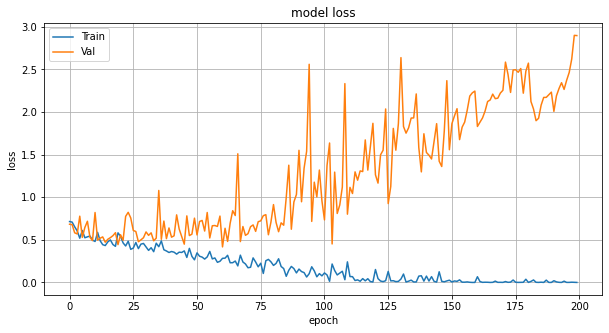

In [6]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.grid()
plt.show()

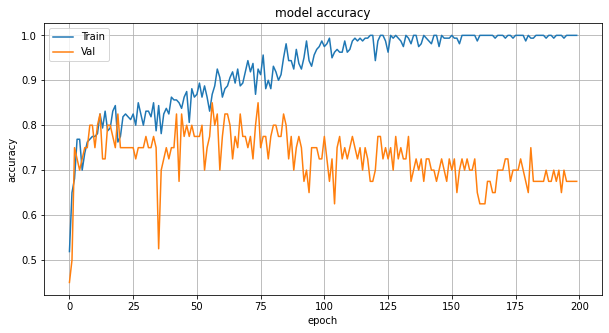

In [7]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['binary_accuracy'])
plt.plot(hist.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.grid()
plt.show()

Test Accuracy:  82.39999999999999%

Misclassification Error rate: 0.17600000000000005

Confusion Matrix
 [[402  89]
 [ 87 422]]


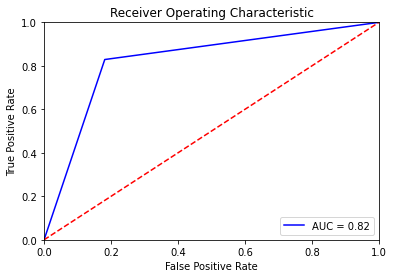

In [8]:
pt = np.array(list(map(np.round,p)))

print(f'Test Accuracy:  {100*metrics.accuracy_score(ty, pt)}%\n')
print(f'Misclassification Error rate: {1 - metrics.accuracy_score(ty, pt)}\n')
print('Confusion Matrix\n' ,metrics.confusion_matrix(ty, pt))

fpr, tpr, threshold = metrics.roc_curve(ty, pt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()